# Real estate Analytics


In [1]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

### Data sourcing

In [2]:
# Collection of datasets on site : https://www.data.gouv.fr/fr/datasets/demandes-de-valeurs-foncieres/ 

links = ["https://www.data.gouv.fr/fr/datasets/r/09f013c5-9531-444b-ab6c-7a0e88efd77d",
         "https://www.data.gouv.fr/fr/datasets/r/0ab442c5-57d1-4139-92c2-19672336401c",
         "https://www.data.gouv.fr/fr/datasets/r/7161c9f2-3d91-4caf-afa2-cfe535807f04",
         "https://www.data.gouv.fr/fr/datasets/r/1be77ca5-dc1b-4e50-af2b-0240147e0346",
         "https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2",
         "https://www.data.gouv.fr/fr/datasets/r/90a98de0-f562-4328-aa16-fe0dd1dca60f"]

data = pd.DataFrame()

for i in range(len(links)):

  link = links[i]
  filename = 'file_'+ str(i)

  try:
    r = requests.get(link, allow_redirects=True) # Get url
    open(filename, 'wb').write(r.content) # Create a file with the url content

    if i==0:
      data = pd.read_table(filename,sep='|') # Read the first file
    else:
      data = pd.concat([data, pd.read_table(filename,sep='|')]) # Concatenate all files

  except:
    print("An error has occured while uploading data")
    break
  
# Dislay first data
data.head()


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (18,23,24,26,28,30,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (18,23,24,26,28,30,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (18,23,24,26,28,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (14,18,23,24,26,28,29,31,32,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,Code service CH,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,Valeur fonciere,No voie,B/T/Q,Type de voie,Code voie,Voie,Code postal,Commune,Code departement,Code commune,Prefixe de section,Section,No plan,No Volume,1er lot,Surface Carrez du 1er lot,2eme lot,Surface Carrez du 2eme lot,3eme lot,Surface Carrez du 3eme lot,4eme lot,Surface Carrez du 4eme lot,5eme lot,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01/07/2015,Vente,"200000,00",17.0,NaN,LOT,A001,DU CLOS DES ACACIAS,1340.0,SAINT-DIDIER-D AUSSIAT,1,346,NaN,AI,326,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,85.0,4.0,S,NaN,932.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01/07/2015,Vente,"95000,00",1189.0,NaN,NaN,0501,DES VILLAGES,1250.0,HAUTECOURT-ROMANECHE,1,184,327.0,C,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,116.0,6.0,S,NaN,185.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01/07/2015,Vente,"77000,00",NaN,NaN,NaN,B084,CORVEISSIAT,1250.0,CORVEISSIAT,1,125,NaN,E,501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,J,NaN,302.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01/07/2015,Vente,"77000,00",18.0,NaN,RUE,0230,SOUS L ORME,1250.0,CORVEISSIAT,1,125,NaN,E,1502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,Maison,NaN,50.0,4.0,S,NaN,176.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,01/07/2015,Vente,"40000,00",281.0,NaN,AV,0140,DE MACON,1440.0,VIRIAT,1,451,NaN,BL,45,NaN,32,NaN,62,"30,19",NaN,NaN,NaN,NaN,NaN,NaN,2,2.0,Appartement,NaN,29.0,1.0,NaN,NaN,NaN


In [3]:
# Dislay dimensions

data.shape

(15152581, 43)

### Data cleaning



In [4]:
# Delete useless columns 

for c in data.columns:
   if c not in ['Date mutation', 
                'Nature mutation', 
                'Valeur fonciere',
                'Commune',
                'Code commune',
                'Code departement', 
                'Code type local', 
                'Type local', 
                'Surface reelle bati', 
                'Nombre pieces principales', 
                'Surface terrain']:
      del data[c]

# Delete NaN data, duplicates, and display

data = data.dropna()
data.head()

,Date mutation,Nature mutation,Valeur fonciere,Commune,Code departement,Code commune,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain
0,01/07/2015,Vente,"200000,00",SAINT-DIDIER-D AUSSIAT,1,346,1.0,Maison,85.0,4.0,932.0
1,01/07/2015,Vente,"95000,00",HAUTECOURT-ROMANECHE,1,184,1.0,Maison,116.0,6.0,185.0
3,01/07/2015,Vente,"77000,00",CORVEISSIAT,1,125,1.0,Maison,50.0,4.0,176.0
7,03/07/2015,Vente,"320130,00",BUELLAS,1,65,1.0,Maison,188.0,8.0,1293.0
10,06/07/2015,Vente,"140000,00",FOISSIAT,1,163,1.0,Maison,89.0,6.0,818.0


In [5]:
# Display dimensions

data.shape

(4129516, 11)

In [6]:
# Convert prices, dates and display types

data['Valeur fonciere'] = data['Valeur fonciere'].str.replace(',','.')
data['Valeur fonciere'] = pd.to_numeric(data['Valeur fonciere'])
data['Date mutation'] = pd.to_datetime(data['Date mutation'], infer_datetime_format=True)

data.dtypes

Date mutation                datetime64[ns]
Nature mutation                      object
Valeur fonciere                     float64
Commune                              object
Code departement                     object
Code commune                          int64
Code type local                     float64
Type local                           object
Surface reelle bati                 float64
Nombre pieces principales           float64
Surface terrain                     float64
dtype: object

### Average prices per year, department and type of goods


In [7]:
# Average prices according to years, department and type of goods

average = data.groupby([data['Date mutation'].dt.year,'Code departement','Type local'])['Valeur fonciere'].mean().reset_index()
average

,Date mutation,Code departement,Type local,Valeur fonciere
0,2015,1,Appartement,250662.155317
1,2015,1,Dépendance,228471.498547
2,2015,1,Local industriel. commercial ou assimilé,381430.059589
3,2015,1,Maison,256527.132072
4,2015,2,Appartement,181776.957522
...,...,...,...,...
2359,2020,2A,Maison,732667.073333
2360,2020,30,Appartement,452888.481724
2361,2020,30,Dépendance,387075.978601
2362,2020,30,Local industriel. commercial ou assimilé,484453.710526


In [8]:
# For example Average prices for 2017 and Gard Departement according to type local

average.loc[(average["Date mutation"]==2017) & (average["Code departement"]==30)]

,Date mutation,Code departement,Type local,Valeur fonciere
904,2017,30,Appartement,590246.280894
905,2017,30,Dépendance,566291.581577
906,2017,30,Local industriel. commercial ou assimilé,705871.332160
907,2017,30,Maison,248927.195221


### Visualization: ratio between the surface area of a good and its price per m², according to the good and town

* Tools :

  * Data visualization : Pandas, NumPy, GPS coordinates datasets

* Steps :

  * Import the longitudes / latitudes of the different communes in order to display the map of France with a scatter plot

  * Selection of area, price, type of property and municipality 

  * Scaling evaluation (price per m²)

  * Grouping of scaling by municipalities
  
  * Display of visuals







In [9]:
# Collection of datasets on site : https://freakonometrics.hypotheses.org/1125
# Download a csv with all the longitudes/latitudes of the municipalities of France

link="http://freakonometrics.free.fr/popfr19752010.csv"
filename='file_geo'

try:
  r = requests.get(link, allow_redirects=True) 
  open(filename, 'wb').write(r.content) 

except:
  print("An error has occured while uploading data")

datageo = pd.read_csv(filename,sep=',')[['com_nom','long','lat']]
datageo = datageo.rename(columns={"com_nom":"Commune"})

datageo.head()

,Commune,long,lat
0,PARIS,2.352222,48.856614
1,ACHERES-LA-FORET,2.570289,48.354976
2,AUBEPIERRE-OZOUER-LE-REPOS,2.890552,48.632323
3,CHATELET-EN-BRIE,2.792095,48.504945
4,CHATENAY-SUR-SEINE,3.096229,48.418774


/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove

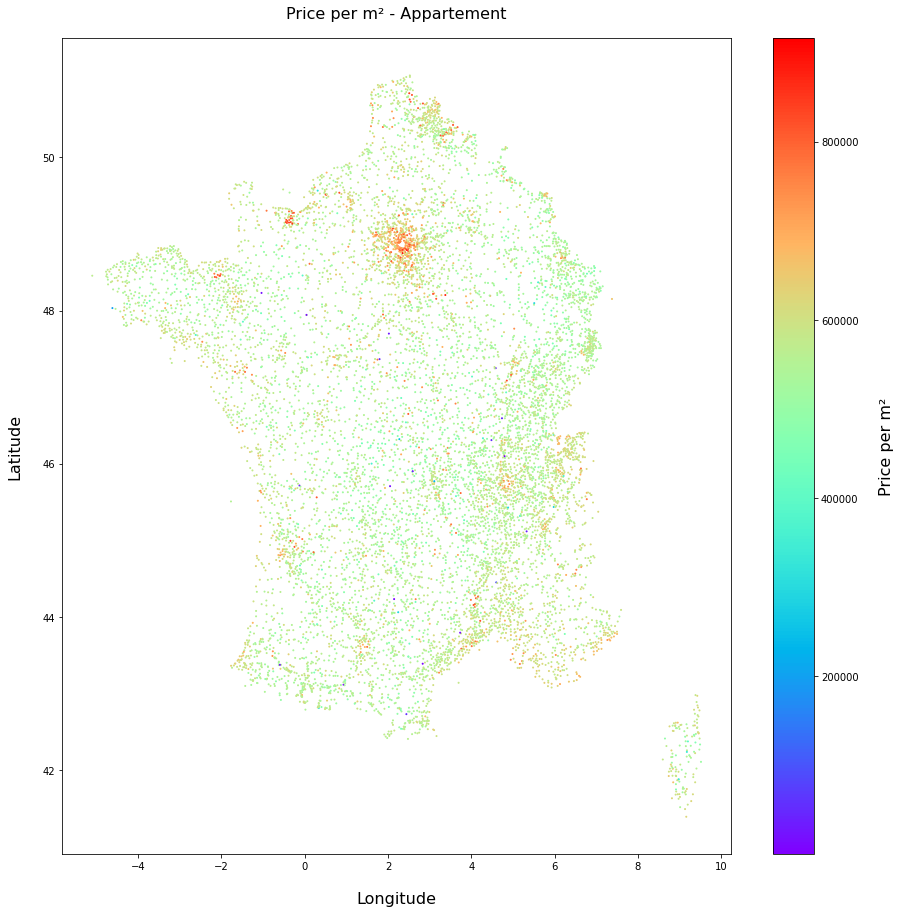

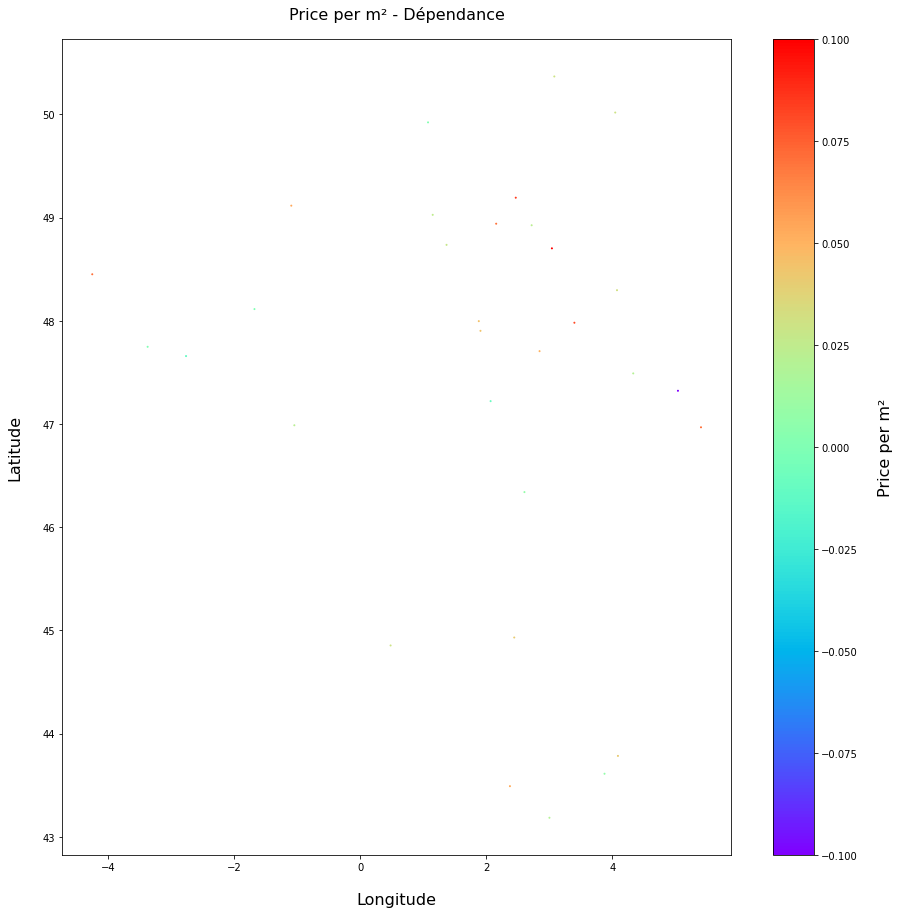

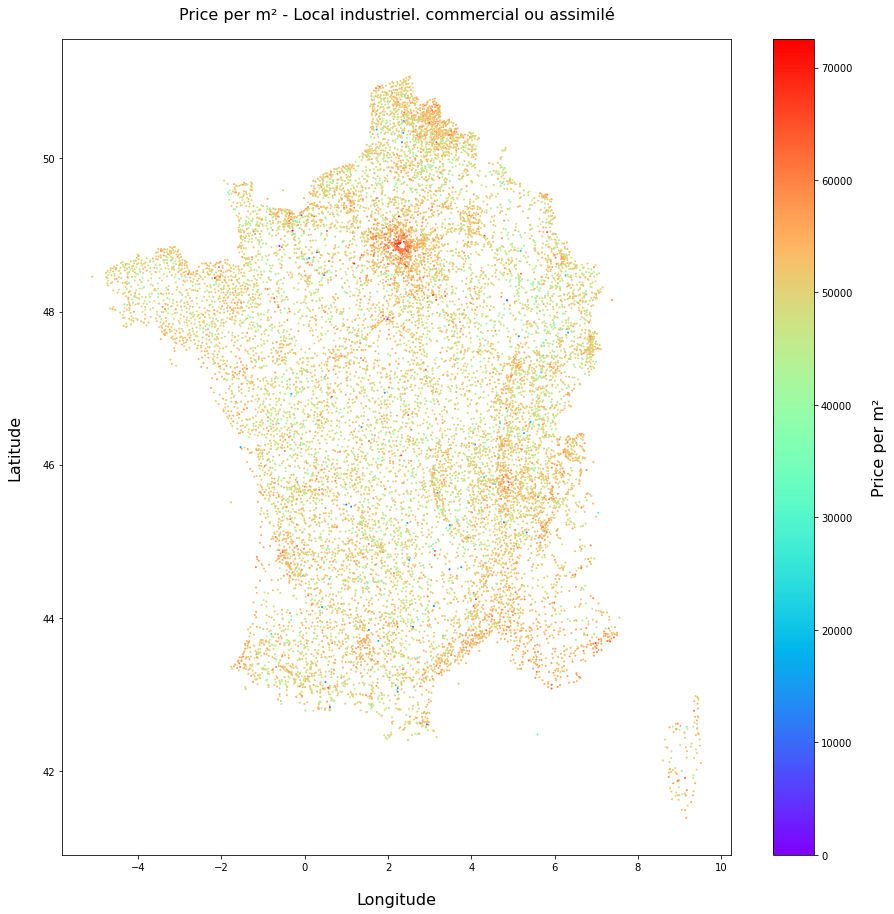

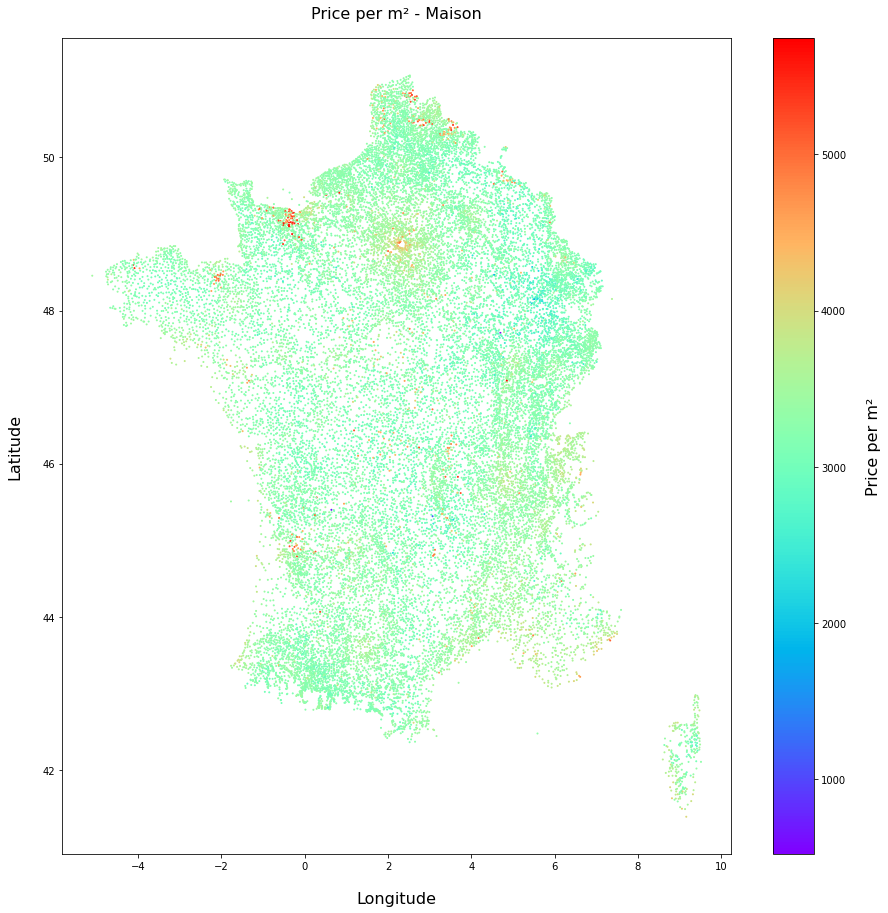

In [10]:
# Selection of area, price, type of property and municipality

for i in ['Appartement','Dépendance','Local industriel. commercial ou assimilé','Maison']:

  data_local = data[['Valeur fonciere','Commune','Surface reelle bati','Type local']]
  data_local = data_local.loc[data_local['Type local']==i]

# Scaling = price per m²

  scaling = np.array(data_local['Valeur fonciere']) / np.array(data_local['Surface reelle bati'])

  for j in np.where(data_local['Surface reelle bati']==0)[0]:
    scaling[j] = 0

  data_local['scaling'] = scaling

# Merging and grouping of the two dataframes in relation to the names of the municipalities

  datageo_local = datageo.merge(data_local, on='Commune').groupby(['Commune']).mean()
  datageo_local.dropna()

# Visual display and data standardization

  fig = plt.figure(figsize=(15,15))
  ax = plt.gca()

  norm = clr.Normalize(vmin=np.quantile(scaling, 0.05), vmax=np.quantile(scaling, 0.95))
  cmap = plt.cm.rainbow

  ax.scatter(datageo_local['long'], datageo_local['lat'], s=1, c=np.log(datageo_local['scaling']), cmap=cmap)
  ax.set_title("Price per m² - {}".format(i), fontsize=16, pad=20)
  ax.set_xlabel("Longitude", fontsize=16, labelpad=20)
  ax.set_ylabel("Latitude", fontsize=16, labelpad=20)

  sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
  cbar = fig.colorbar(sm)
  cbar.set_label('Price per m²', fontsize=16, labelpad=20)

### Identification of periods of market stress

* Tools :

  * Data visualization : Pandas, NumPy, Seaborn

* Steps :

  * Display of the number of sales

  * Standardization of data to keep distances between variables

  * Display of the reduced number of sales 
  
  * Realization of a pivot table
  
  * Display of the pivot table as a heat map

In [11]:
# Creation of a "Nombre vente" column which records each sale and display

data['Nombre vente'] = 1
data.head()

,Date mutation,Nature mutation,Valeur fonciere,Commune,Code departement,Code commune,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre vente
0,2015-01-07,Vente,200000.0,SAINT-DIDIER-D AUSSIAT,1,346,1.0,Maison,85.0,4.0,932.0,1
1,2015-01-07,Vente,95000.0,HAUTECOURT-ROMANECHE,1,184,1.0,Maison,116.0,6.0,185.0,1
3,2015-01-07,Vente,77000.0,CORVEISSIAT,1,125,1.0,Maison,50.0,4.0,176.0,1
7,2015-03-07,Vente,320130.0,BUELLAS,1,65,1.0,Maison,188.0,8.0,1293.0,1
10,2015-06-07,Vente,140000.0,FOISSIAT,1,163,1.0,Maison,89.0,6.0,818.0,1


In [12]:
# Aggregation of the number of sales by type of local and months

nbvente = data.groupby([data['Date mutation'].dt.to_period('M'),'Type local'])['Nombre vente'].count().reset_index()
nbvente

,Date mutation,Type local,Nombre vente
0,2015-01,Appartement,1678
1,2015-01,Dépendance,1260
2,2015-01,Local industriel. commercial ou assimilé,922
3,2015-01,Maison,7652
4,2015-02,Appartement,1336
...,...,...,...
283,2020-11,Maison,5501
284,2020-12,Appartement,1317
285,2020-12,Dépendance,740
286,2020-12,Local industriel. commercial ou assimilé,648


In [13]:
# For reduced_col, return a new array of given shape and type, filled with zeros

reduced_col = np.zeros(len(nbvente))

for s in ['Appartement','Dépendance','Local industriel. commercial ou assimilé','Maison']:

# Returns the standard deviation of the number of sales for each type of goods

  tmp_sd = np.std(nbvente[nbvente['Type local'] == s]['Nombre vente'])

# Get the reduced number of sales column by dividing by the standard deviation

  reduced_col[np.where(nbvente['Type local'] == s)] = 1 / tmp_sd * np.array(nbvente[nbvente['Type local']==s]['Nombre vente'])

nbvente['Nombre de vente réduit'] = reduced_col
nbvente

,Date mutation,Type local,Nombre vente,Nombre de vente réduit
0,2015-01,Appartement,1678,0.319954
1,2015-01,Dépendance,1260,0.404784
2,2015-01,Local industriel. commercial ou assimilé,922,0.460007
3,2015-01,Maison,7652,0.435939
4,2015-02,Appartement,1336,0.254743
...,...,...,...,...
283,2020-11,Maison,5501,0.313395
284,2020-12,Appartement,1317,0.251120
285,2020-12,Dépendance,740,0.237730
286,2020-12,Local industriel. commercial ou assimilé,648,0.323302


In [14]:
# Realization of a pivot table to implement the heatmap

heatmap = pd.pivot_table(data=nbvente, index='Type local', values='Nombre de vente réduit', columns='Date mutation')

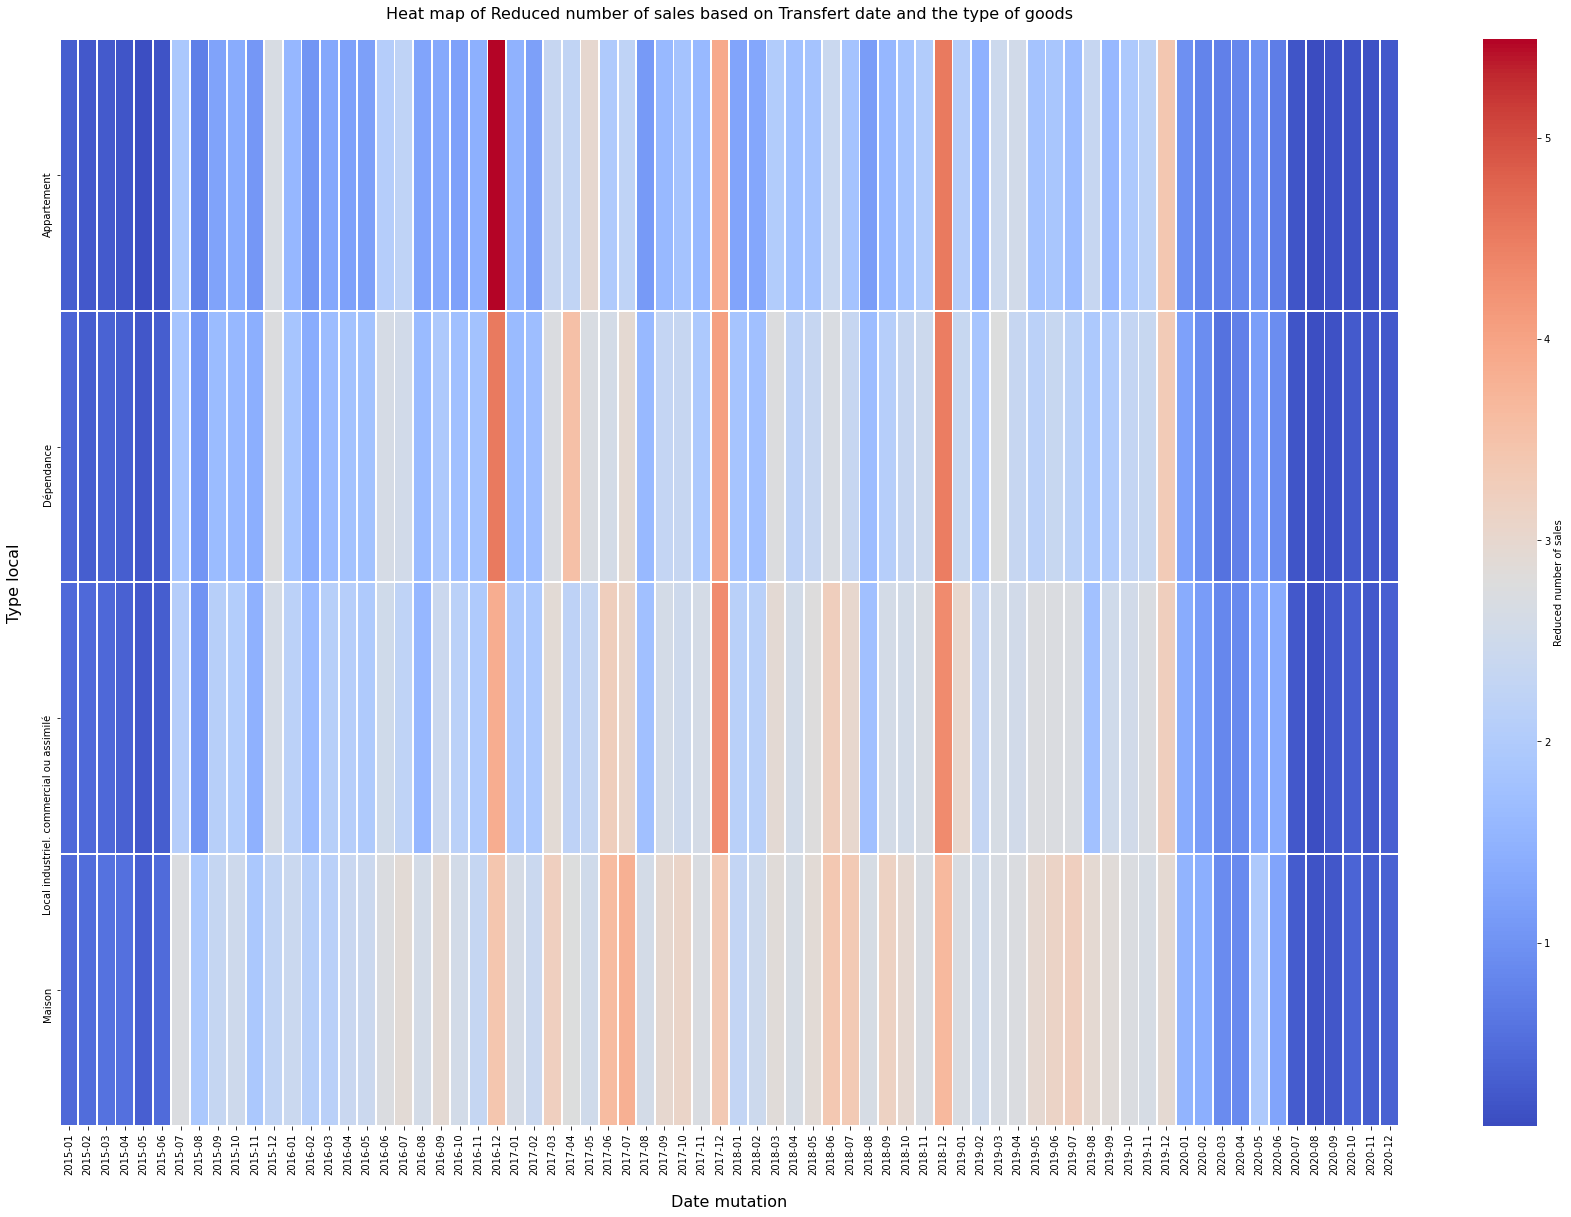

In [15]:
# Draw a heatmap with the numeric values in each cell

f, ax = plt.subplots(figsize=(30, 20))
ax.set_xlabel("Local type", fontsize=16, labelpad=20)
ax.set_ylabel("Transfert year", fontsize=16, labelpad=20)
ax.set_title('Heat map of Reduced number of sales based on Transfert date and the type of goods', fontsize=16, pad=20)

sns.heatmap(heatmap, cmap='coolwarm', linewidths=1, ax=ax, cbar_kws={'label': 'Reduced number of sales'})

* Thus, the sales were compared to usual :

  * In the second half of 2015 and the first half of 2020 approximately twice as high for all types of goods.

  * In the four months of December 2016, 2017, 2018, 2019 approximately 4 times higher for all types of goods.

  * Over the month of December 2016 about 5 times higher for apartments.


* The 4 strong periods of tension on the market are at the level of the months of December between 2016 and 2019.

* For the first half of 2015 and the second half of 2020 sales are lower than usual because we do not have the datasets.

### Unsupervised asset classification method

* Tools :

  * Data modeling : K-means (one of the best known / only quantitative data)

  * Data visualization : PCA (to reduce the size and project R7 into R3)

* Steps :

  * Keeping quantitative data

  * Standardize data

  * Try to partition the n points into k clusters by minimizing the distance between the points within each partition

  * The function to be minimized is consequently the sum of the squares of these distances

  * Display the model

#### Data prepocessing


In [16]:
data.head()

,Date mutation,Nature mutation,Valeur fonciere,Commune,Code departement,Code commune,Code type local,Type local,Surface reelle bati,Nombre pieces principales,Surface terrain,Nombre vente
0,2015-01-07,Vente,200000.0,SAINT-DIDIER-D AUSSIAT,1,346,1.0,Maison,85.0,4.0,932.0,1
1,2015-01-07,Vente,95000.0,HAUTECOURT-ROMANECHE,1,184,1.0,Maison,116.0,6.0,185.0,1
3,2015-01-07,Vente,77000.0,CORVEISSIAT,1,125,1.0,Maison,50.0,4.0,176.0,1
7,2015-03-07,Vente,320130.0,BUELLAS,1,65,1.0,Maison,188.0,8.0,1293.0,1
10,2015-06-07,Vente,140000.0,FOISSIAT,1,163,1.0,Maison,89.0,6.0,818.0,1


In [17]:
# Remove almost all categorical data
# Keep the type of goods which is important for classification

Xtrain = data[['Valeur fonciere','Type local','Surface reelle bati', 'Surface terrain']]

# get_dummies converts the remaining categorical variable into dummy variables / indicators

Xtrain = pd.get_dummies(Xtrain,columns=['Type local'])
Xtrain.head()

,Valeur fonciere,Surface reelle bati,Surface terrain,Type local_Appartement,Type local_Dépendance,Type local_Local industriel. commercial ou assimilé,Type local_Maison
0,200000.0,85.0,932.0,0,0,0,1
1,95000.0,116.0,185.0,0,0,0,1
3,77000.0,50.0,176.0,0,0,0,1
7,320130.0,188.0,1293.0,0,0,0,1
10,140000.0,89.0,818.0,0,0,0,1


#### PCA & K-means

In [18]:
# Standardize data (centered reduced)

Xtrain = StandardScaler().fit_transform(Xtrain)
print(Xtrain[:5,:])

[[-0.12939426 -0.03536272 -0.06829391 -0.40601173 -0.33180401 -0.27455307
   0.67151497]
 [-0.13550142 -0.01157396 -0.11018302 -0.40601173 -0.33180401 -0.27455307
   0.67151497]
 [-0.13654837 -0.06222101 -0.11068771 -0.40601173 -0.33180401 -0.27455307
   0.67151497]
 [-0.12240707  0.04367738 -0.04805031 -0.40601173 -0.33180401 -0.27455307
   0.67151497]
 [-0.13288407 -0.03229321 -0.07468663 -0.40601173 -0.33180401 -0.27455307
   0.67151497]]


In [19]:
# Projection of data in R3 for a 3D plan
# Standardize data (centered reduced)

cov_matrix = PCA(n_components=3) 
XXtrain = cov_matrix.fit_transform(Xtrain)

# Percentage of variance for the 3 components (partial inertia/factorial axis)

cov_matrix.explained_variance_ratio_ 

array([0.26457619, 0.1713323 , 0.16583228])

In [20]:
XXtrain

array([[-0.89733673, -0.07272301,  0.07366719],
       [-0.90248704, -0.0581129 ,  0.06783361],
       [-0.90512337, -0.08257613,  0.05180344],
       ...,
       [ 1.94762952,  2.57413617,  0.86858919],
       [ 2.03200209, -1.18782284,  0.82270534],
       [ 1.66864747,  2.82769371,  0.61572478]])

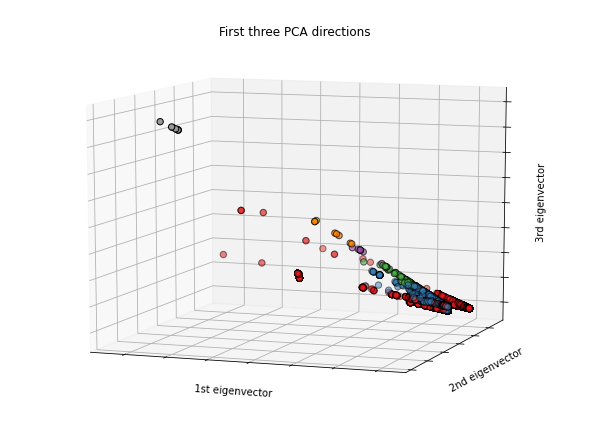

In [21]:
# Plot the first three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(XXtrain[:, 0], XXtrain[:, 1], XXtrain[:, 2], c=XXtrain[:, 1], cmap=plt.cm.Set1, edgecolor='k', s=40)
      
ax.set_title("First three PCA directions")

ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])

ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax.view_init(10)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


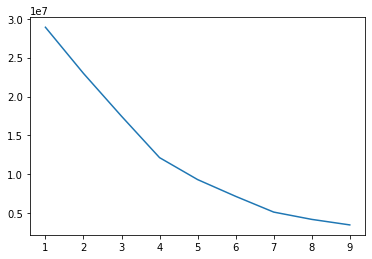

In [22]:
# Find the number k of clusters thanks to the loss function (inertia)
# Calculation of the sum of the squared distances of the samples to their nearest cluster center 

inertias=[]

for k in range(1,10): 
  
  tmp_model = KMeans(n_clusters=k,n_jobs=2).fit(Xtrain)
  inertias.append(tmp_model.inertia_)

plt.plot(range(1,10),inertias)

I take 4 clusters because the inertia gain is less important for higher values.

In [23]:
# Best version 

best_model = KMeans(n_clusters=4,n_jobs=2).fit(Xtrain)

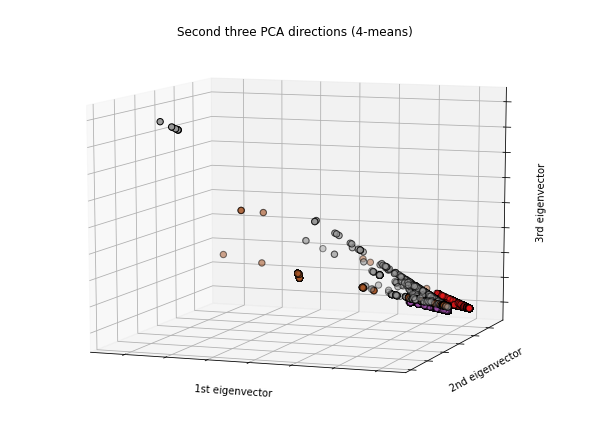

In [24]:
labels = best_model.labels_

# Plot the second three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(XXtrain[:, 0], XXtrain[:, 1], XXtrain[:, 2], c=labels, cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title("Second three PCA directions (4-means)")

ax.set_xlabel("1st eigenvector") 
ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])

ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax.view_init(10)


### Outliers detection method

* Tools :

  * Data modeling : Empirical approaches using quantiles

  * Data visualization : PCA (to reduce the size, to highlight outliers)

* Steps :

  * Consider as outliers the points that have a large (Euclidean) distance from the center of gravity of their cluster

  * In other words, those that weigh heavily on the creation of their cluster

  * Take 5% as margin of error / percentage of outliers

  * Display outliers

In [25]:
# For all the elements of the distance matrix, I take the min to have the vector of distances to the centers of gravity

dists = np.array([min(tmp) for tmp in best_model.transform(Xtrain)]) 

In [26]:
# 5% of the data are outliers

q = np.quantile(dists, 0.95) 
outliers = np.where(dists>q)[0]
outliers

array([     75,     507,     508, ..., 4129510, 4129512, 4129513])

In [27]:
print(len(outliers))
print(np.shape(Xtrain))

206476
(4129516, 7)


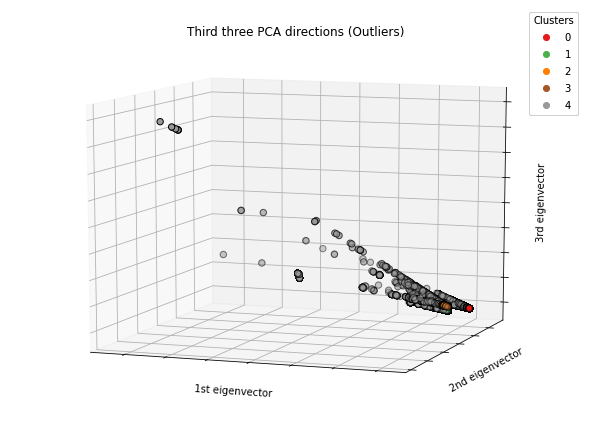

In [28]:
labels_outliers = labels
labels_outliers[outliers] = 4

# plot the third three PCA dimensions

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
scatter3 = ax.scatter(XXtrain[:, 0], XXtrain[:, 1], XXtrain[:, 2], c=labels, cmap=plt.cm.Set1, edgecolor='k',s=40)

ax.set_title("Third three PCA directions (Outliers)")

ax.set_xlabel("1st eigenvector") 
ax.w_xaxis.set_ticklabels([])

ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])

ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

ax.view_init(10)

legend1 = ax.legend(*scatter3.legend_elements(), loc="best", title="Clusters")
ax.add_artist(legend1)